In [1]:
import joblib
import mne
import os
import matplotlib.pyplot as plt
from collections import Counter
from add_subject_utils import depth, get_subj_data
import pandas as pd

In [2]:
mne.set_log_level("error")

In [17]:
# checking the channels
dir = r"D:\Shaked_data\clean_with_scalp"
files = sorted(os.listdir(dir))
files = [x for x in files if x.split(".")[0][-2:] != "-1"]
scalp_by_subject = {}
print(f"Number of subjects: {len(files)}")
for file in files:
    sub = file.split("_")[0][1:]
    raw = mne.io.read_raw(os.path.join(dir, file))
    if any(x in raw.ch_names for x in ["C3", "C4", "F3", "F4"]):
        scalp_by_subject[sub] = [x for x in ["C3", "C4", "F3", "F4"] if x in raw.ch_names]
        
print(f"Number of subjects with scalp: {len(scalp_by_subject)}")

Number of subjects: 34
Number of subjects with scalp: 34


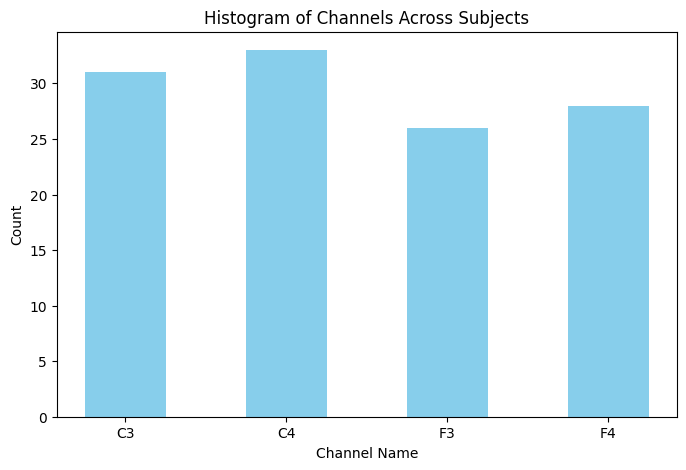

In [ ]:
all_channels = [ch for channels in scalp_by_subject.values() for ch in channels]
channel_counts = Counter(all_channels)

plt.figure(figsize=(8, 5))
plt.bar(channel_counts.keys(), channel_counts.values(), color='skyblue', width=0.5)
plt.xticks()
plt.xlabel("Channel Name")
plt.ylabel("Count")
plt.title("Histogram of Channels Across Subjects")
plt.show()

In [19]:
channel_counts

Counter({'C4': 33, 'C3': 31, 'F4': 28, 'F3': 26})

In [2]:
# Running parameters

model_name = "lgbm_full_f15_s25_b_V5.pkl"
use_all_channels = True
confidence = 0.8
num_channels_agreement = 2

In [3]:
# run depth model for creating labels
depth_model, features = joblib.load(rf"D:\user\Desktop\Noa_Regev\Students\Shaked\{model_name}").values()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
sub = "49"
clean_raw = mne.io.read_raw_fif(fr'D:\Shaked_data\clean_with_scalp\P{sub}_mtl_clean.fif')
nan_clean = clean_raw.get_data(reject_by_annotation='NaN')
nan_raw = mne.io.RawArray(nan_clean, clean_raw.info)

Opening raw data file D:\Shaked_data\clean_with_scalp\P49_mtl_clean.fif...
Isotrak not found
    Range : 0 ... 5699999 =      0.000 ...  5699.999 secs
Ready.


C:\Users\user\AppData\Local\Temp\ipykernel_12588\3200951642.py:2: RuntimeWarning: This filename (D:\Shaked_data\clean_with_scalp\P49_mtl_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean_raw = mne.io.read_raw_fif(fr'D:\Shaked_data\clean_with_scalp\P{sub}_mtl_clean.fif')


Setting 254814 of 5700000 (4.47%) samples to NaN, retaining 5445186 (95.53%) samples.
Creating RawArray with float64 data, n_channels=11, n_times=5700000
    Range : 0 ... 5699999 =      0.000 ...  5699.999 secs
Ready.


In [ ]:
# extract depth features - example for one channel (all channels in next cell)
chan = 'LAH1'
curr_data = nan_raw.pick(chan)
curr_data.crop(60 * 60 * 1 + 60 * 20, 60 * 60 * 1 + 60 * 25)
subj_data = get_subj_data(curr_data, chan, sub, depth=True)
prob = depth_model.predict_proba(subj_data[features])[:, 1]
y_depth = (prob >= confidence).astype(int)

In [ ]:
# get only one deepest channel from each location
if not use_all_channels:
    min_indexes = {}
    for item in curr_chans:
        prefix = item[:-1]
        index = int(item[-1])
        if prefix not in min_indexes or index < int(min_indexes[prefix][-1][-1]):
            min_indexes[prefix] = item

In [5]:
# extract depth features - all channels
curr_channels = [chan for chan in nan_raw.ch_names if chan in depth]
total_y = None
for chan in curr_channels:
    curr_data = get_subj_data(nan_raw, chan, sub, depth=True)
    predictions = depth_model.predict_proba(curr_data[features])
    curr_y = (predictions[:, 1] >= confidence).astype(int)
    print(f"{chan}: {sum(curr_y)} spikes")
    if total_y is None:
        total_y = curr_y
    else:
        # summing answers from all the channels
        total_y += curr_y

# at least 2 channels should be above threshold
total_y[total_y < num_channels_agreement] = 0
total_y[total_y >= num_channels_agreement] = 1
print(f"Number of spikes: {sum(total_y)}")
print(f"Spikes ratio: {total_y.sum() / len(total_y)}")

LAH1: 63 spikes
LAH2: 10 spikes
RAH1: 854 spikes
RAH2: 24 spikes
Number of spikes: 22
Spikes ratio: 0.0010103793515201616


In [6]:
# extract scalp features
scalp_channels = [["C4", "F4"], ["C4", "F3"]]
for channel_couple in scalp_channels:
    if all(ch in nan_raw.ch_names for ch in channel_couple):
        scalp1 = get_subj_data(nan_raw, channel_couple[0], sub, depth=False)
        scalp2 = get_subj_data(nan_raw, channel_couple[1], sub, depth=False)
        # combine and rename columns
        subj_feat = pd.concat([scalp1, scalp2], axis=1, ignore_index=True) 
        subj_feat.columns = [f'{channel_couple[0]}_{col}' for col in scalp1.columns] + [f'{channel_couple[1]}_{col}' for col in scalp2.columns]
        # save to pkl
        # subj_feat.to_pickle(rf'D:\Bonn\P{subj}_zeeg_feat.pkl')

d:\user\Desktop\Noa_Regev\Students\Shaked\spikes_notebooks\add_subject_utils.py:370: SyntaxWarning: invalid escape sequence '\P'
  clean_raw = mne.io.read_raw_fif(f"{dir_path}\P{subject}_mtl_clean.fif")


MemoryError: Unable to allocate 8.73 GiB for an array with shape (21774, 232, 232) and data type float64

In [66]:
nan_raw.ch_names

['LAH1', 'LAH2', 'RAH1', 'RAH2', 'FZ', 'F4', 'C4', 'P3', 'CZ', 'EOG1', 'EOG2']

In [ ]:
# GPU server: 132.66.34.82

In [4]:
raw = mne.io.read_raw_egi(r'D:\Shaked_data\EL3006_sleep_20220317_011020.mff')

In [6]:
raw.pick(raw.ch_names[:50])
raw.plot()